# Periodical Examination.

## Statistical Analysis On Sigma Cars DataSet.

In [379]:
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm, poisson, ttest_1samp,mannwhitneyu,wilcoxon
from statsmodels.stats.descriptivestats import sign_test

sns.set_theme("notebook", style="whitegrid")
warnings.filterwarnings("ignore")
import statsmodels.graphics.gofplots as gof
from scipy.stats import chi2_contingency, chisquare
from statsmodels.formula.api import ols
from statsmodels.stats import outliers_influence as sm_oi
from statsmodels.stats.anova import anova_lm

In [380]:
def cols_tidy(df_cols):
    df_cols_tidy = []
    for item in df_cols:
        x = re.sub(r" +", " ", item)
        x1 = re.sub(r"\,|\)|\(|\.|\-|\'", "", x)
        x2 = re.sub(r"\/", "_or_", x1)
        x3 = re.sub(r"\&", "_and_", x2)
        x4 = re.sub(r"\s(?=\_{1,})|(\_(?=\s{1,}))|\,", "", x3)
        x5 = re.sub(r" {2,}", " ", x4)
        x6 = re.sub(r"\s", "_", x5)
        x7 = re.sub(r"\:", "", x6)
        df_cols_tidy.append(x7.lower())
    return df_cols_tidy

def calculate_center_line(data, column_name):
    """Calculates the center line for the control chart."""
    return data[column_name].mean()


def calculate_control_limits(center, average_defects_per_unit, multiplier):
    """Calculates upper and lower control limits."""
    std_dev = np.sqrt(average_defects_per_unit)
    upper_limit = center + multiplier * std_dev
    lower_limit = center - multiplier * std_dev
    return upper_limit, lower_limit


def create_run_chart(data, column_name):
    """Creates a run chart for the given data."""
    plt.figure(figsize=(25, 6))
    plt.plot(data.index, data[column_name], marker="o", linestyle="-")
    plt.xlabel(
        "Projects-From Jan to Dec-2023"
    )  # Assuming the index represents time periods
    plt.ylabel(column_name)  # Replace with the actual column name
    plt.title("Run Chart for " + column_name)
    plt.grid(True)
    plt.show()

def get_hypothesis(_p_val):
    if _p_val<0.05:
        print(f'P-Value:{round(_p_val,5)} is less than 0.05 hence we can reject the null hypothesis in favor of alternative hypothesis')
    else:
        print(f'P-Value:{round(_p_val,5)} is greater than 0.05 hence we failed to reject the null hypothesis.')

def custom_ols_qqplot(_resid):
    """Q-Q Plot of residuals"""
    gof.qqplot(_resid, line="s")
    plt.xlabel("Standard Normal Quantiles")
    plt.ylabel("Standardized Residuals")
    plt.title("Normal Q-Q plot")
    plt.show()


def custom_ols_res_vs_fitted(_fitted, _resid):
    """Fitted Vs Residuals Plot"""
    plt.scatter(_fitted, _resid)
    plt.axhline("0", color="r")
    plt.xlabel("Fitted Values")
    plt.ylabel("Residual")
    plt.title("Residual Vs Fitted")


def custom_VIF(_MSPEC):
    """Custom function to get the VIF"""
    var_names = _MSPEC.exog_names
    X = _MSPEC.exog
    _limit = X.shape[1]
    try:
        vif_dict = {}
        for idx in range(_limit):
            vif = round(sm_oi.variance_inflation_factor(X, idx), 5)
            vif_dict[var_names[idx]] = vif
        _DF = pd.DataFrame([vif_dict]).T
        _DF.columns = ["VIF"]
        _DF = _DF.reset_index()
        df_sorted = _DF.iloc[1:].sort_values(by="VIF", ascending=False)
        ax = sns.barplot(x="index", y="VIF", data=df_sorted)
        # Add text labels to the top of each bar
        for bar in ax.containers[0]:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                int(bar.get_height()),
                ha="center",
                va="bottom",
            )
        ax.set_xlabel("FIELD")
        ax.set_ylabel("VIF")
        plt.xticks(rotation=45)
        plt.title("VIF")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        pass

def custom_statsmodel_OLS(_DF, *vars):
    """fitting OLS on specified independent and dependent variables- DF, dependent_var and independent_var"""
    # sm.add_constant
    try:
        LOS_COLS = [v for v in vars]
        _X = LOS_COLS[1:]
        _Y = LOS_COLS[0]
        xvars = sm.add_constant(_DF[_X])
        yvar = _DF[_Y]
        _model_spec = sm.OLS(yvar, xvars)
        return _model_spec
    except Exception as e:
        print(f"There is an error while creating a model spec due to:{e}")

def custom_model_preds(_model, _new_df):
    """Predictions on new data points"""
    _feat = sm.add_constant(_new_df)
    _pred = _model.predict(sm.add_constant(_feat))
    _df_pred = pd.DataFrame(_pred)
    _df_pred.columns = ["predicted_y"]
    return _df_pred


def get_six_sigma_caluclator():
    """ISI Custom SixSigma Calucator"""
    while True:
        ### Inputs
        print(f"-------------------------------------------------")
        print(f"############ Sigma Caluclator Inputs ############")
        print(f"-------------------------------------------------")
        _mean = float(input("Enter the mean:"))
        _sd = float(input("Enter Standard Deviation:"))
        _LSL = float(input("Enter LSL:"))
        _USL = float(input("Enter USL:"))
        # Formulas and caluclations
        ZLSL = (_LSL - _mean) / _sd
        ZUSL = (_USL - _mean) / _sd
        Area_ZLSL = norm.cdf(ZLSL)
        Area_ZUSL = 1 - norm.cdf(ZUSL)
        TOTAL_NC = Area_ZLSL + Area_ZUSL
        YIELD = 1 - TOTAL_NC
        CP_ = (_USL - _LSL) / (6 * _sd)
        _A = (_USL - _mean) / (3 * _sd)
        _B = (_mean - _LSL) / (3 * _sd)
        CPK_ = min(_A, _B)
        SIGMA_LEVEL = round(1.5 + norm.ppf(YIELD), 5)
        DPMO = TOTAL_NC * 1000000
        # Output
        print(f"-------------------------------------------------")
        print(f"#### Summary Report ####")
        print(f"-------------------------------------------------")
        print(f"Total NonConfirmances:{round(TOTAL_NC,5)}")
        print(f"Yield:{round(YIELD,5)}")
        print(f"CP:{round(CP_,5)}")
        print(f"CPK:{round(CPK_,5)}")
        print(f"SIGMA_LEVEL:{round(SIGMA_LEVEL,5)}")
        print(f"DPMO:{round(DPMO,5)}")
        print(f"-------------------------------------------------")
        _next = input(
            "Would you like to continue to use sigma caluclator type 'yes' if so :"
        )
        if _next.lower() == "yes":
            continue
        else:
            print(f"Thanks for using Sigma Caluclator..")
            print(f"#### END ####")
            break

In [381]:
# Data Importings
df_cars = pl.read_csv(r"/Users/malleshamyamulla/Desktop/SSBBA/CARS.csv")
df_cars.columns = cols_tidy(df_cars.columns)
df_cars_pd = df_cars.to_pandas()

### Glance at Car Data

In [382]:
df_cars_pd.head()

,make,fueltype,aspiration,enginelocation,numofdoors,drivewheels,fuelsystem,bodystyle,enginetype,numofcylinders,...,enginesize,bore,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,_insurance_risk_rating,car_price
0,alfa-romero,gas,std,front,two,rwd,mpfi,convertible,dohc,four,...,130,3.47,2.68,9.0,111,5000,21,27,High,13495
1,alfa-romero,gas,std,front,two,rwd,mpfi,convertible,dohc,four,...,130,3.47,2.68,9.0,111,5000,21,27,High,16500
2,alfa-romero,gas,std,front,two,rwd,mpfi,hatchback,ohcv,six,...,152,2.68,3.47,9.0,154,5000,19,26,Medium,16500
3,audi,gas,std,front,four,fwd,mpfi,sedan,ohc,four,...,109,3.19,3.40,10.0,102,5500,24,30,High,13950
4,audi,gas,std,front,four,4wd,mpfi,sedan,ohc,five,...,136,3.19,3.40,8.0,115,5500,18,22,High,17450


### Q3.A: Identify Top-7 Car Makers.

In [383]:
# car makes group by operation
df_causes = (
    df_cars.group_by("make")
    .count()
    .with_columns(pl.sum("count").alias("tot_"))
    .with_columns(pl.col("count") / pl.col("tot_"))
    .drop("tot_")
    .sort("count", descending=True)
    .with_columns(pl.col("count").alias("RPN"))
    .drop("count")
    .to_pandas()
)

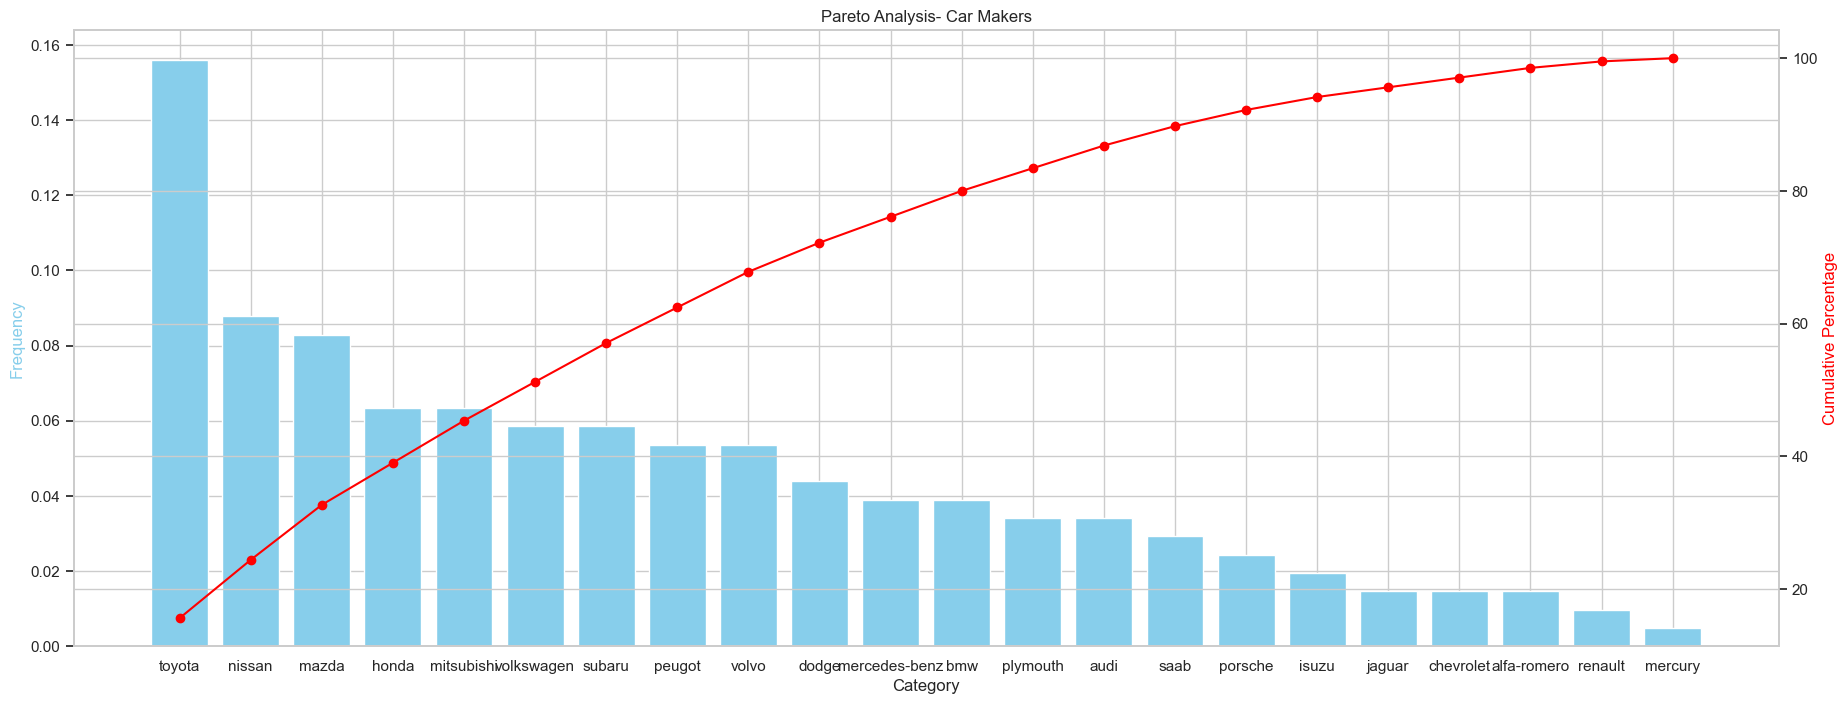

In [384]:
# Pareto Diagram
sorted_data = df_causes.sort_values(by=["RPN"], ascending=False)
sorted_data["cumulative_freq"] = sorted_data["RPN"].cumsum()
sorted_data["cumulative_pct"] = (
    sorted_data["cumulative_freq"] / sorted_data["RPN"].sum() * 100
)

# Visualizations
fig, ax1 = plt.subplots(figsize=(22, 8))
ax2 = ax1.twinx()
ax1.bar(sorted_data["make"], sorted_data["RPN"], color="skyblue")
ax2.plot(
    sorted_data["make"],
    sorted_data["cumulative_pct"],
    color="red",
    marker="o",
    linestyle="-",
)
ax1.set_xlabel("Category")
ax1.set_ylabel("Frequency", color="skyblue")
ax2.set_ylabel("Cumulative Percentage", color="red")
plt.title("Pareto Analysis- Car Makers")
plt.show()

**Inference**

The below car makers are found to be top 7 performares in car sales.

- toyota 
- nissan 
- mazda 
- mitsubishi 
- honda
- subaru
- volkswagen

### Q3.B:Stability and Capability Analysis on City Mpg Variable

#### Stability Analysis.

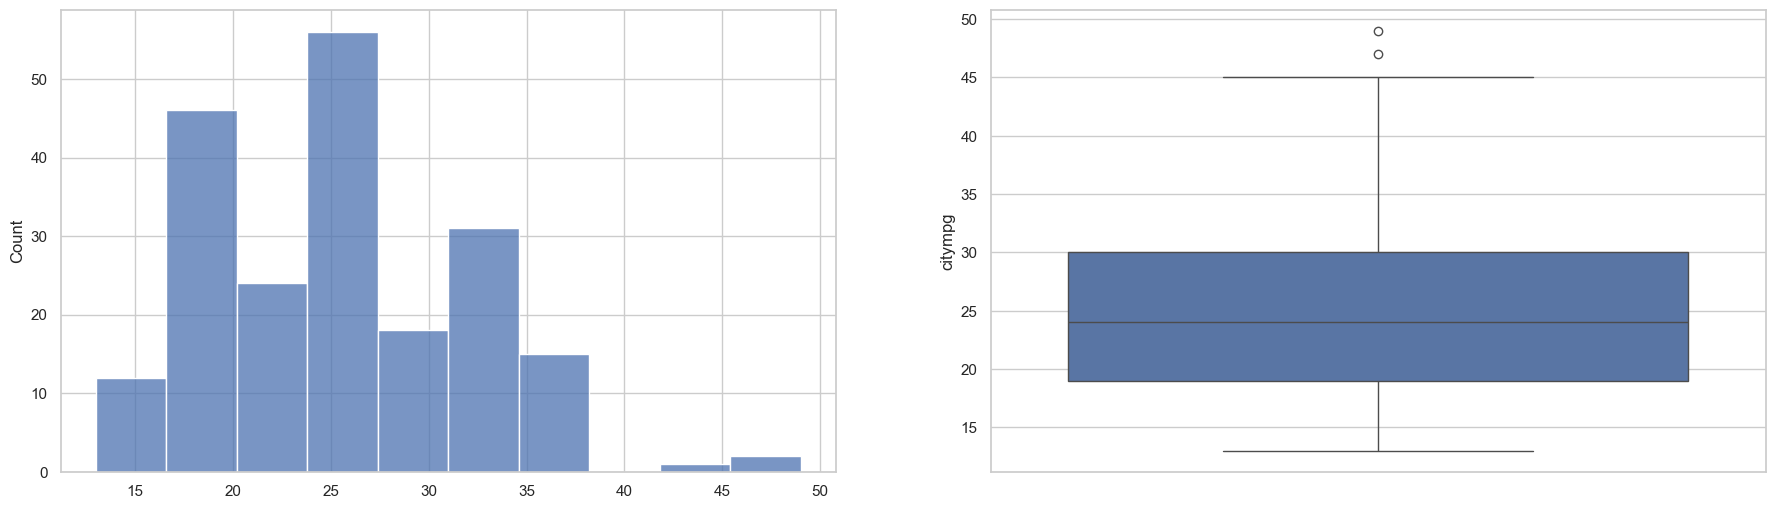

In [385]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
p1=sns.histplot(df_cars["citympg"],ax=ax1)
p2=sns.boxplot(df_cars["citympg"].to_pandas(),ax=ax2)
plt.show()

**Notes**

1. Cars citympg data contains 2 assignable causes i.e citympg are more than 45, they are kept a side and will carry out the stability analysis on it.

In [386]:
df_city_mpg = df_cars.select(["citympg"]).filter(pl.col("citympg") < 43)

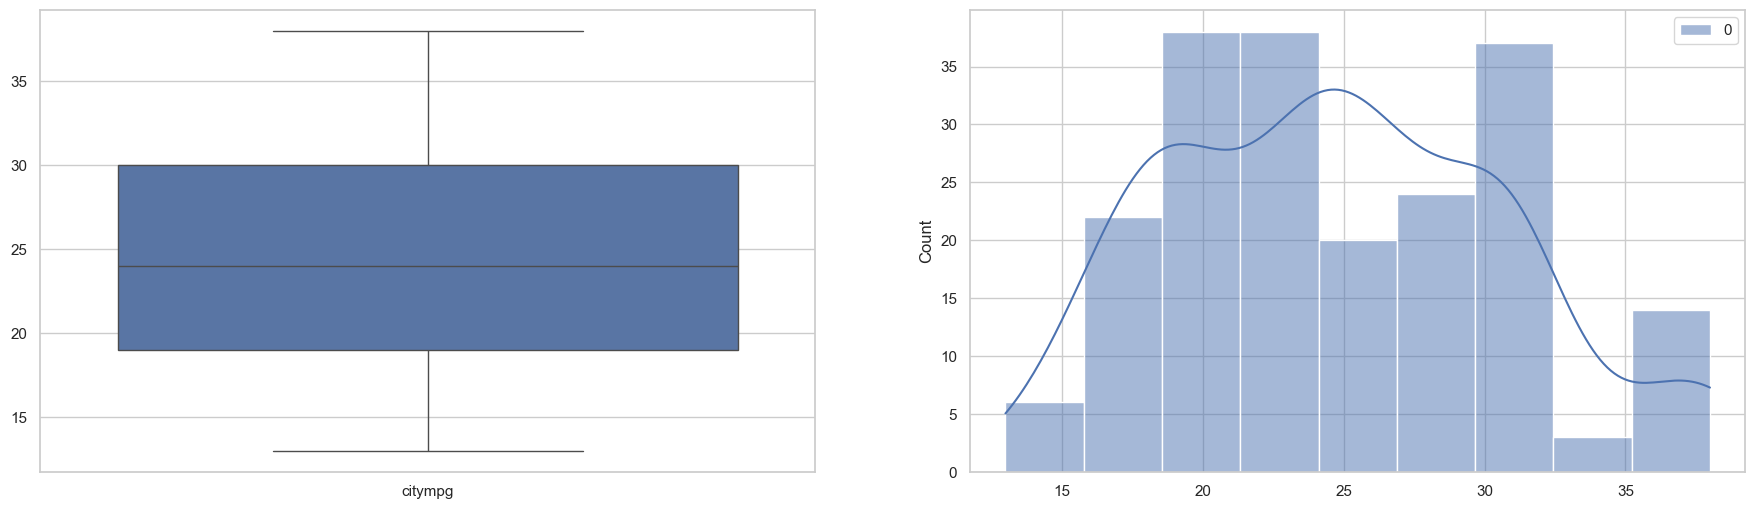

In [387]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
sns.boxplot(df_city_mpg.select(["citympg"]).to_pandas(),ax=ax1)
sns.histplot(df_city_mpg, kde=True,ax=ax2)
plt.show()
plt.show()

In [388]:
df_city_mpg.to_pandas().describe().T

,count,mean,std,min,25%,50%,75%,max
citympg,202.0,24.89604,6.017725,13.0,19.0,24.0,30.0,38.0


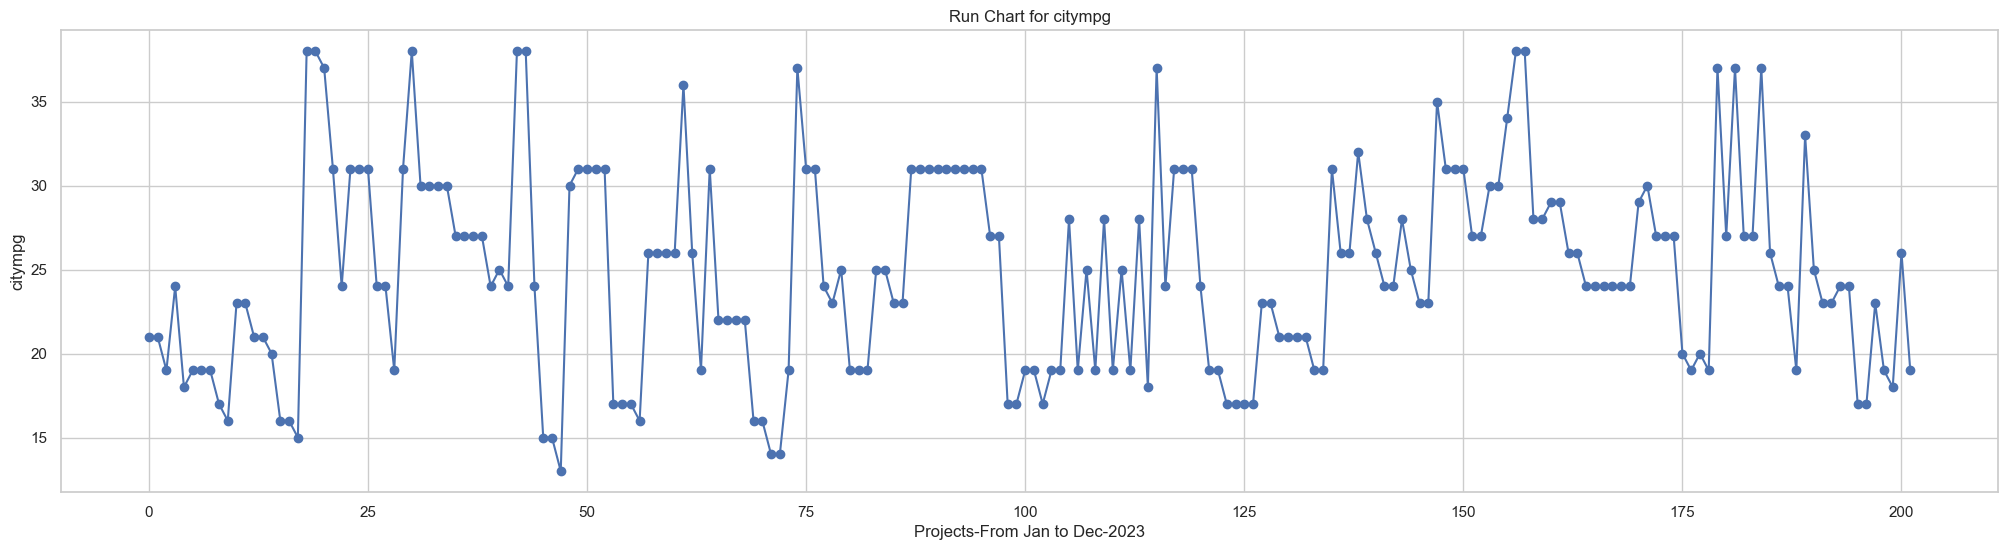

In [389]:
create_run_chart(df_city_mpg.to_pandas(), "citympg")

**Inferences**

1. After removing the assignable the random chances are found to be nearly normal distributed, with a mean of 23.89 and standard deviation of 6.01.
   
2. Mean and Median Values are found to approximately equal.
   
3. The run chart shows no trends, neither upward nor downward.
   
4. In a conclusion the process is found to be statistically stable one.

#### Capability Analysis

Below are the Business Specifications


    0. CTQ: Car city MPG should alteast be 20.
    1. Mean: avg city-mpg ~ 24.89
    2. SD:   Standard Deviation ~ 6.01
    3. Tolerances:
         - LSL: ~ 20
         - USL: ~ 38(Max MPG found from the given data)

In [390]:
#get_six_sigma_caluclator()

**Caluclated Performance Metrics on citympg:**

- Total NonConfirmances:0.2225
- Yield:0.7775
- CP:0.49917
- CPK:0.27121
- SIGMA_LEVEL:2.26377
- DPMO:222502.72038

**Inferences**:

1. **Cp(0.49):** This value suggests the process is not very capable of consistently producing cars that meet the CTQ  of 20 MPG city mileage.
   
2. **Cpk(0.27):**  Cpk is lower than Cp, it means that the process isn't performing well relative to the CTQ
   
3. **Sigma Level(2.2):** Process Spread is lower.
 
4. **DPMO(222502):** This represents the estimated number of cars per million that would not meet the city MPG criteria based on the current process performance.
 
5. **Yield(0.7775):** - This indicates the proportion of cars (77.75%) that meet or exceed the city MPG requirement of at least 20.
 
6. **NC(0.25):** This represents the proportion of cars (22.25%) that have a city MPG below the minimum acceptable standard of 20.

### Q3.C: Sigma Cars management wants to target on average $12000 or above price segment,do they have potential business, test the requirement using the approproate test?

**Hypothesis**

            Ho: The average selling price of cars at Sigma Cars is less than 1200.
            Ha: The average selling price of cars at Sigma Cars is equal to or greater than 1200.

**Descriptive Stas on CarPrice**

In [391]:
print(f'Descriptive Statistics of car price:')
pd.DataFrame(df_cars_pd['car_price'].describe()).T

Descriptive Statistics of car price:


,count,mean,std,min,25%,50%,75%,max
car_price,205.0,13243.243902,7941.72182,5118.0,7788.0,10295.0,16503.0,45400.0


**CarPrice Distribution**

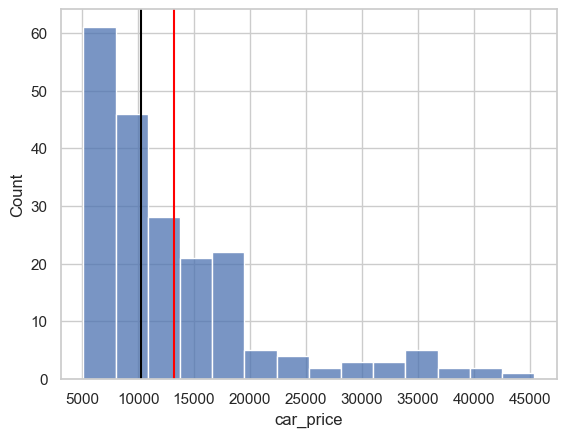

In [392]:
sns.histplot(df_cars_pd['car_price'])
plt.axvline(13243,color='red')
plt.axvline(10295,color='black')
plt.show()

**Notes**

1. Total Number of observation 205.
   
2. Car prices data exhibits a right skewed distribution.
 
3. Car Price mean(13243) is found be greater than median value(10295) as its right skewed distribution
 
4. Car Price is not normally distributed, however the sample size is large enough i.e 205 so it would be ok to carry out 1 Sample T-test to test the postulated hypothesis.

In [393]:
_stat_3c,_p_value_3c= ttest_1samp(df_cars_pd['car_price'],popmean=12000,alternative='greater')
_3_1_1st=ttest_1samp(df_cars_pd['car_price'],popmean=12000,alternative='greater')
_low,_high=_3_1_1st.confidence_interval()
get_hypothesis(_p_value_3c)

P-Value:0.01304 is less than 0.05 hence we can reject the null hypothesis in favor of alternative hypothesis


**Inferences**

1. I have carried out a one-sample t-test(One-tailed) on car price to see if the car price is on or above 12000.
   
2. The caluclated p-value(0.013) suggest that we can reject the null hypothesis in favor of alternative meaning The average selling price of cars at Sigma Cars is equal to or greater than 1200 and the sigma cars would have a potential business to do.

In [394]:
df_cars_pd.loc[df_cars_pd['car_price']>=12000,'car_price_seg']='>12000'
df_cars_pd.loc[df_cars_pd['car_price']<12000,'car_price_seg']='<12000'

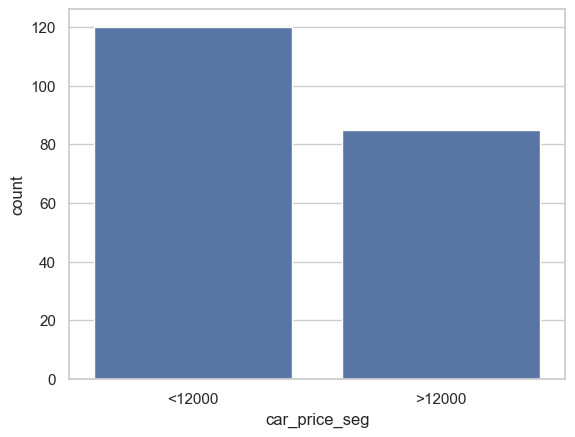

In [395]:
sns.barplot(pd.DataFrame(df_cars_pd['car_price_seg'].value_counts()).reset_index(),x='car_price_seg',y='count')
plt.show()

**Notes**


I have categorized car prices into two groups such as <12000 and >=12000 and 40% of the car prices fall into the higher price segment (at or above 12000).

### Q3.D: Which among the following four variables/feature have the price advantage. Postulate the appropriate hypothesis and test

    - fueltype
    - aspiration
    - enginelocation
    - numofdoors

In [396]:
df_3d = df_cars_pd[['fueltype', 'aspiration','numofdoors','enginelocation','car_price']]

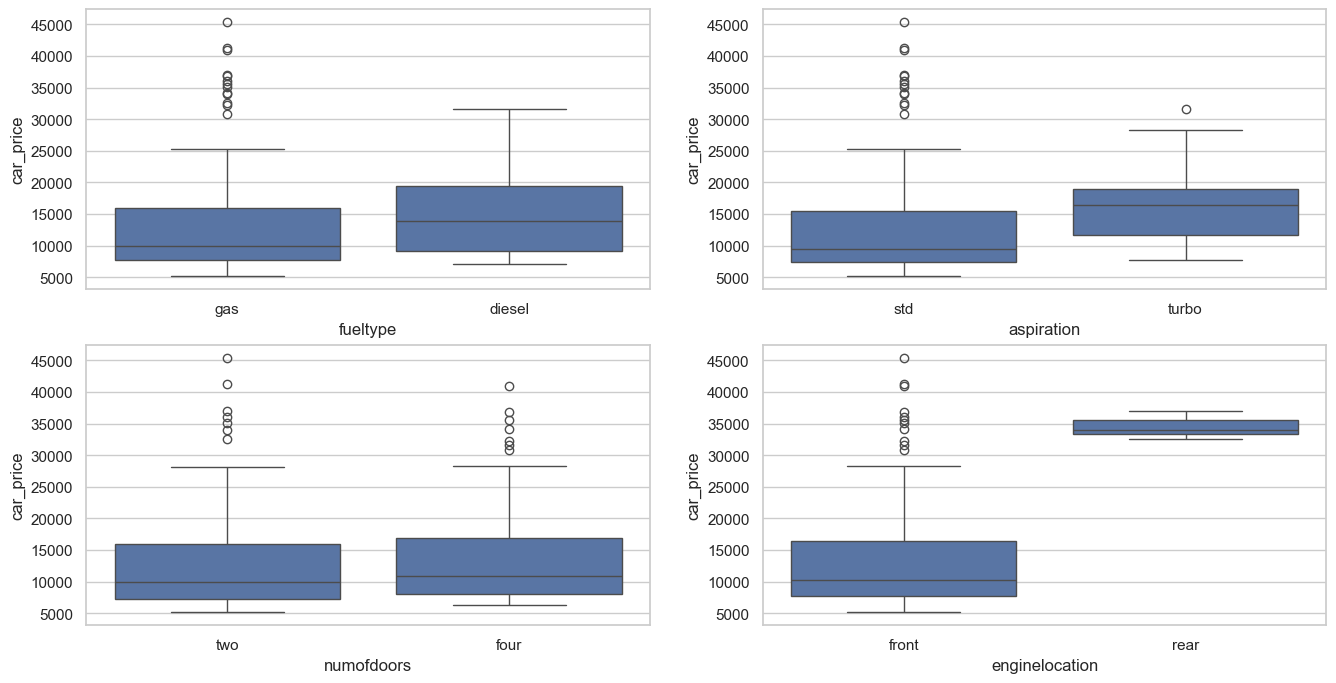

In [397]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
sns.boxplot(x='fueltype',y='car_price',data=df_3d,ax=axes[0,0])
sns.boxplot(x='aspiration',y='car_price',data=df_3d,ax=axes[0,1])
sns.boxplot(x='numofdoors',y='car_price',data=df_3d,ax=axes[1,0])
sns.boxplot(x='enginelocation',y='car_price',data=df_3d,ax=axes[1,1])
plt.show()

In [398]:
# Define the model formula
df_3d_model = ols(
    "car_price ~ fueltype+aspiration+enginelocation+numofdoors", data=df_3d
).fit()

# Perform ANOVA
anova_table_3d = anova_lm(df_3d_model)

# Print ANOVA results
anova_table_3d.apply(lambda x:round(x,5))

,df,sum_sq,mean_sq,F,PR(>F)
fueltype,1.0,1.492298e+08,1.492298e+08,2.74410,0.09918
aspiration,1.0,2.987693e+08,2.987693e+08,5.49390,0.02006
enginelocation,1.0,1.480249e+09,1.480249e+09,27.21943,0.00000
numofdoors,1.0,6.181319e+07,6.181319e+07,1.13665,0.28765
Residual,200.0,1.087641e+10,5.438206e+07,NaN,NaN


**Inferences:**


1. The variables fueltype, aspiration, enginelocation and numofdoors are having the same number of degrees of freedom.
   
2. FuelType: F value 2.77 and P-value 0.09.It's not significant as it has higher p-value than 0.05
 
3. Aspiration: F Value 5.49 and P-value 0.002. It's a statistical significant variable with lower p-value less than 0.02

4. Enginelocation: F-Value 27.21 and P-Value 0.0, It's also a statistical significant variable with lower p-value less than 0.0

5. Numofdoors: F-Value 6.18 and P-Value 0.28. sIt's not significant as it has higher p-value than 0.05
    
6. In a conclusion: Aspiration and EngineLocation Variable would have an advantage in car pricing. If we were to select only of these two enginee location would be the most appropriate variable in car pricing.

### Q3.E: Analyze Drive Wheels and Fuel System for statistically testing the average price difference, Postulate the appropriate hypothesis and test.

**Hypothesis**

            Ho: There is no statistically significant difference in the average price of cars between drive wheel and fuel systems.
            Ha: There is a statistically significant difference in the average price of cars between drive wheel and fuel systems.

In [399]:
df_3e = df_cars_pd[['drivewheels','fuelsystem','car_price']]

#### VIS: CarPrice vs (DriveWheels and FuelSystem)

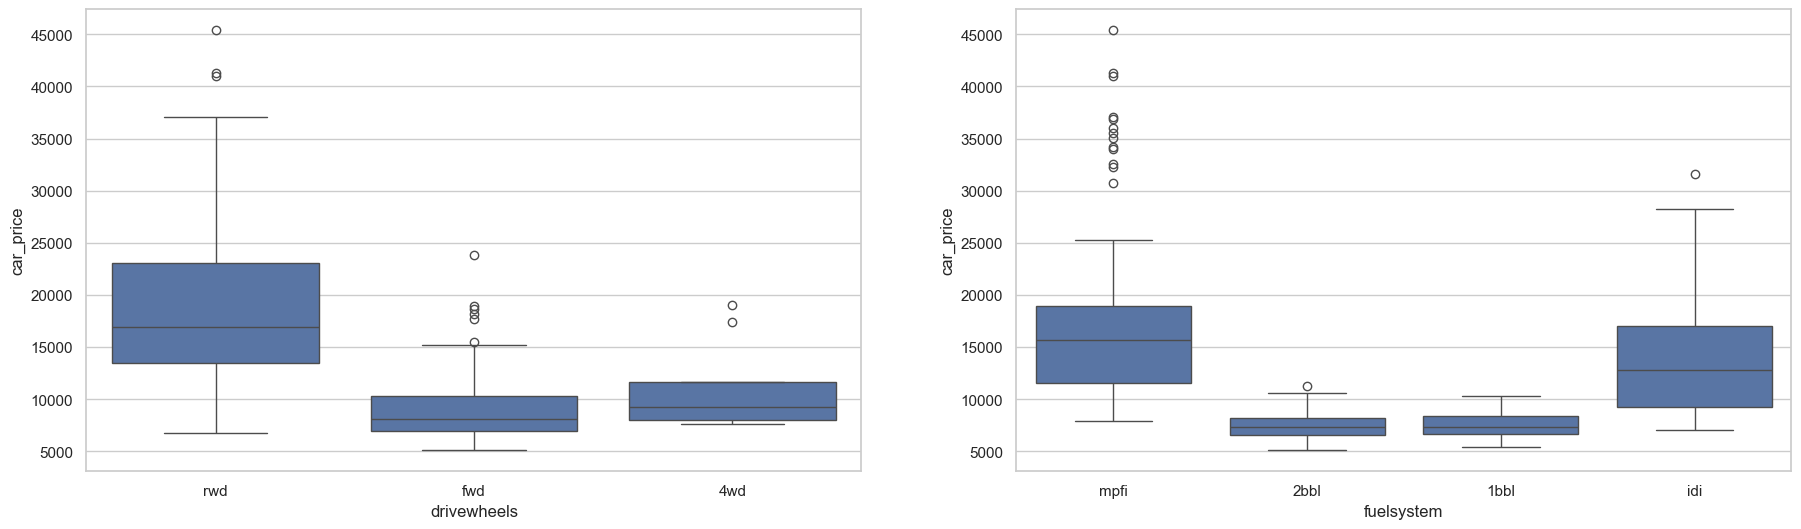

In [400]:
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
sns.boxplot(x='drivewheels',y='car_price',data=df_3e,ax=ax1)
sns.boxplot(x='fuelsystem',y='car_price',data=df_3e,ax=ax2)
plt.show()

#### ANOVA TABLE: CarPrice ~ Drivewheels and FuelSystem.

In [401]:
# Define the model formula
df_3e_model = ols(
    "car_price ~ drivewheels+fuelsystem", data=df_3e
).fit()

# Perform ANOVA
anova_table_3e = anova_lm(df_3e_model)

# Print ANOVA results
anova_table_3e.apply(lambda x:round(x,5))

,df,sum_sq,mean_sq,F,PR(>F)
drivewheels,2.0,5.274374e+09,2.637187e+09,79.15850,0.00000
fuelsystem,3.0,9.623598e+08,3.207866e+08,9.62882,0.00001
Residual,199.0,6.629739e+09,3.331527e+07,NaN,NaN


**Inferences:**

1. The variables DriveWheel and fuelsystem are having the different number of degrees of freedom. 2 and 3 respectively.
   
2. DriveWheel: F value 79.15 and P-value 0.0 suggest to reject the null hypothesis.
   
3. FuelType: F Value 9.62 and P-value 0.0 also suggest to reject the null hypothesis.
   
4. Drivewheel F-Value is much higher than to FuelType, This suggests a potentially stronger effect of drive wheel on car price compared to fuel type.
   
5. In a conclusion: There is a statistically significant difference in the average price of cars between drive wheel and fuel systems.

### Q3.F: Is there any significance difference in average pricing with different body styles. Similarly does engine type plays a significant role in altering the average price. Postulate the appropritate hypothesis and test.

**Hypothesis-1**

            Ho: On average, the price of a car isn't affected by its body style.
            Ha: On average, the price of a car is affected by its body style.


**Hypothesis-2**

            Ho: On average, the price of a car isn't affected by its engine type.
            Ha: On average, the price of a car is affected by its engine type.

In [402]:
df_3f = df_cars_pd[['bodystyle','enginetype','car_price']]

#### VIS: BodyStye vs car prices AND EngineType Vs CarPrice

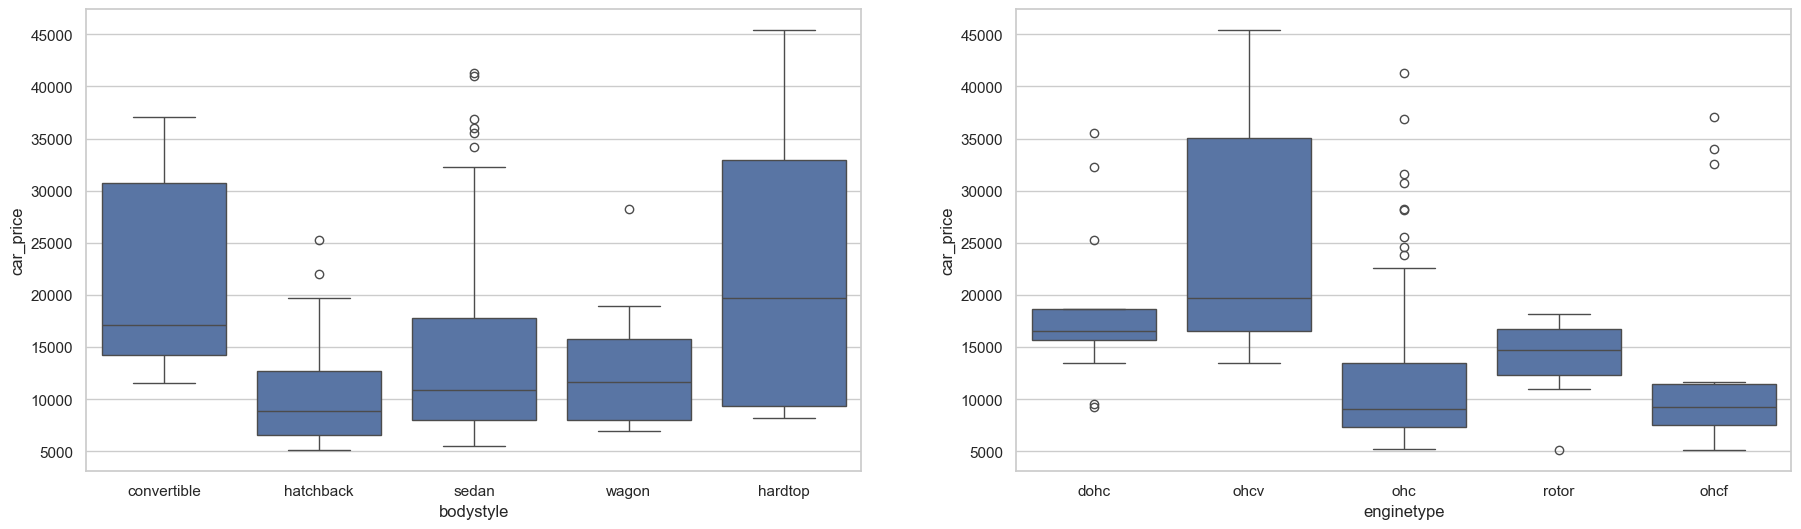

In [403]:
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
sns.boxplot(x='bodystyle',y='car_price',data=df_3f,ax=ax1)
sns.boxplot(x='enginetype',y='car_price',data=df_3f,ax=ax2)
plt.show()

#### ANOVA TABLE: CarPrice ~ BodyStyle and EngineType.

In [404]:
# Define the model formula
df_3f_model = ols(
    "car_price ~ bodystyle+enginetype", data=df_3f
).fit()

# Perform ANOVA
anova_table_3f = anova_lm(df_3f_model)

# Print ANOVA results
anova_table_3f.apply(lambda x:round(x,5))

,df,sum_sq,mean_sq,F,PR(>F)
bodystyle,4.0,1.826663e+09,4.566658e+08,10.25081,0.0
enginetype,4.0,2.308158e+09,5.770395e+08,12.95284,0.0
Residual,196.0,8.731652e+09,4.454924e+07,NaN,NaN


**Inferences:**

1. The variables Bodystyle and Engine type are having the same number of degrees of freedom.
   
2. Bodystyle: F value 10.25 and P-value 0.0 suggest to reject the null hypothesis.
 
3. EngineType: F Value 12.95 and P-value 0.0 also suggest to reject the null hypothesis.
 
4. EngineType F-Value is little higher than to Bodytype.
 
5. In a conclusion: The average car price is affected by both BodyStyle and EngineType.

### Q3.G: Number of cylinders are critical to engine power and performance therefore result in different pricing. postulate the appropriate hypothesis.

**Hypothesis**

            Ho: The average car price is the same across all cylinder levels-there is no statistically significant relationship between the number of cylinders in a car and its average selling price. 
            Ha: at least one mean car price is different across all cylinder levels-There is a statistically significant relationship between the number of cylinders in a car and its average selling price.

In [405]:
df_3g=df_cars_pd[['numofcylinders','car_price']]

#### VIS:Number of cylinders vs car prices.

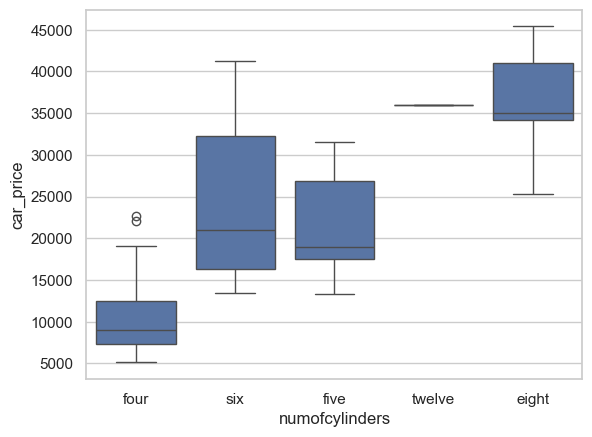

In [406]:
sns.boxplot(x='numofcylinders',y='car_price',data=df_3g)
plt.show()

**Notes**

1. The Numofcylinders are having 5 levels.
   
2. The carprice data per each of these levels is distributed differently from the above box plot. The boxplot reveals that the distribution of car prices differs significantly across these cylinder levels.

#### ANOVA TABLE: Car Price ~ Number of cylinders

In [407]:
# Define the model formula
df_3g_model = ols(
    "car_price ~ numofcylinders", data=df_3g
).fit()

# Perform ANOVA
anova_table_3g = anova_lm(df_3g_model)

# Print ANOVA results
anova_table_3g.apply(lambda x:round(x,5))

,df,sum_sq,mean_sq,F,PR(>F)
numofcylinders,4.0,7.964193e+09,1.991048e+09,81.22947,0.0
Residual,200.0,4.902280e+09,2.451140e+07,NaN,NaN


**Inferences**

1. From the ANOVA Table: For the numofcylinders variable The F-Value is moderately high i.e 81.22 while the caluclated P value(0.0)  suggest that we can reject the null hypothesis in favor of alternative i.e the Mean car prices are different across the numberof cylinders.

### Q3.H: Fuel System does have an association with insurance risk where as engine tye is not expected to have any association with insurance risk.How will you test the theory ?

**Hypothesis:1**

        Ho: The insurance risk ratings are same for all Fuel Systems, Engine type does not have any association with insurance risk There is no association between the fuelsystem and insurance risk rating levels.
        
        Ha: The distribution of insurance risk ratings differs from each Fuel System,There is an association between the fuelsystem and insurance risk rating levels.
        

**Hypothesis:2**

            Ho: The insurance risk ratings are same for all engine types, Engine type does not have any association with insurance risk.
            Ha: The distribution of insurance risk ratings differs from each engine type, engine type does have an association.

In [408]:
df_3h=df_cars_pd[['fuelsystem','enginetype','_insurance_risk_rating']]
df_3h_agg=df_3h.groupby(['fuelsystem', '_insurance_risk_rating']).count().reset_index()
df_3h_agg1=df_3h.groupby(['enginetype', '_insurance_risk_rating']).count().reset_index()

**VIS-1:FuelSystem ~ Insurance_Risk_Rating**

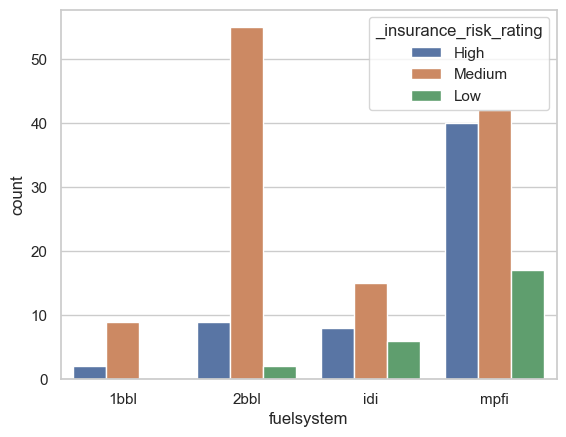

In [409]:
sns.barplot(
    df_3h_agg, x="fuelsystem", y="enginetype", hue="_insurance_risk_rating"
)
plt.ylabel('count')
plt.show()

**Notes:**

1. There are four levels of fuel system and 3 levels of insurance risk rating.
2. The graph shows the counts of each insurance risk rating per each of fuel system.
3. Fuel system 1bbl has only got 2 insurance ratings, and the other 3 have the three different risk ratings in different proportions.

**VIS-2:EngineType ~ Insurance_Risk_Rating**

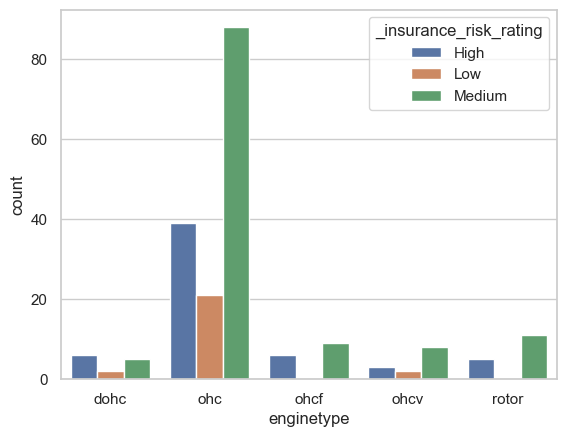

In [410]:
sns.barplot(
    df_3h_agg1, x="enginetype", y="fuelsystem", hue="_insurance_risk_rating"
)
plt.ylabel('count')
plt.show()

**Notes:**

1. There are 5 levels of enginetype and 3 levels of insurance risk rating.
2. The graph shows the counts of each insurance risk rating per each of engine system.
3. All engine types have got the insurance risk rating, 4 of th engine type levels are found to be having very similar proportions across the three risk rating categories.

#### ChiSuare Associaton test: FuelSystem and Insurance Risk Rating

In [411]:
## Chi-Square Test-1
df_ecom_CT = pd.crosstab(df_3h["fuelsystem"], df_3h["_insurance_risk_rating"]).reset_index().drop(["fuelsystem"], axis=1)

CS_LVEL = df_ecom_CT.to_numpy()

_chi2, _pvalue, _ddof, _expected = chi2_contingency(CS_LVEL)

get_hypothesis(_pvalue)

P-Value:1e-05 is less than 0.05 hence we can reject the null hypothesis in favor of alternative hypothesis


#### ChiSuare Associaton test: EngineType and Insurance Risk Rating

In [412]:
## Chi-Square Test-1
df_ecom_CT = pd.crosstab(df_3h["enginetype"], df_3h["_insurance_risk_rating"]).reset_index().drop(["enginetype"], axis=1)

CS_LVEL = df_ecom_CT.to_numpy()

_chi2_, _pvalue_cs, _ddof1, _expected1 = chi2_contingency(CS_LVEL)

get_hypothesis(_pvalue_cs)

P-Value:0.4149 is greater than 0.05 hence we failed to reject the null hypothesis.


**Conclusions**

1. The ChiSquare Associaton test on EngineType and Insurance Risk Rating suggests that the Engine type does not have any association with insurance risk. here with higher p-value we failed to reject the null hypothesis.

### Q3.I: Regression Analysis

In [413]:
los_con_cols = [
    "wheelbase",
    "length",
    "width",
    "height",
    "curbweight",
    "enginesize",
    "bore",
    "stroke",
    "compressionratio",
    "horsepower",
    "peakrpm",
    "citympg",
    "highwaympg",
    "car_price",
]

In [414]:
df_cars_v1 = df_cars_pd[los_con_cols]

#### Glance at Data- All continous variables(Predictors and Response)

In [415]:
df_cars_v1.head()

,wheelbase,length,width,height,curbweight,enginesize,bore,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,car_price
0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495
1,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500
2,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500
3,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950
4,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450


#### Correlation matrix

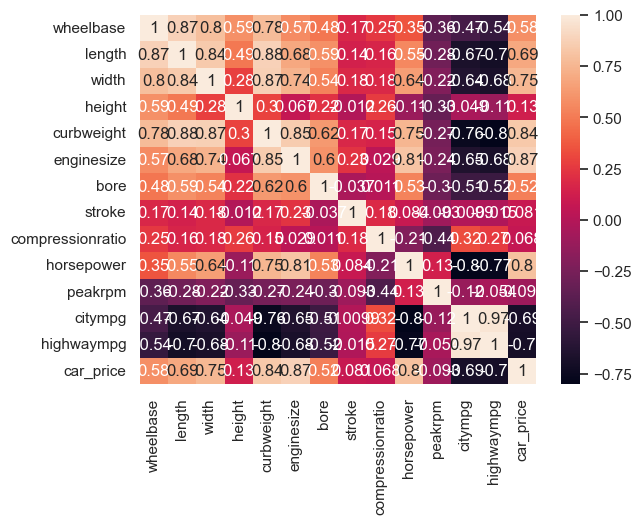

In [416]:
sns.heatmap(df_cars_v1.corr(), annot=True)
plt.show()

In [417]:
X = sm.add_constant(df_cars_v1.drop(["car_price"], axis=1))
Y = df_cars_v1["car_price"]
_model_spec = sm.OLS(Y, X)
_MODEL_FIT = _model_spec.fit()

#### Trial-1 Model Fitting.

In [418]:
print(f'Trial-1#The Regression Table:##\n{_MODEL_FIT.summary2()}')

Trial-1#The Regression Table:##
                       Results: Ordinary least squares
Model:                  OLS                 Adj. R-squared:        0.838     
Dependent Variable:     car_price           AIC:                   3904.1448 
Date:                   2024-04-12 21:13    BIC:                   3950.6669 
No. Observations:       205                 Log-Likelihood:        -1938.1   
Df Model:               13                  F-statistic:           82.05     
Df Residuals:           191                 Prob (F-statistic):    8.95e-71  
R-squared:              0.848               Scale:                 1.0230e+07
-----------------------------------------------------------------------------
                    Coef.     Std.Err.     t    P>|t|     [0.025     0.975]  
-----------------------------------------------------------------------------
const            -37199.2505 14901.3433 -2.4964 0.0134 -66591.5838 -7806.9173
wheelbase           106.6533   100.7882  1.0582 0.2913 

**Inferences**
  
1. The fitted model has producted: R-SQuared IS (0.84) adn R-Squared(Adj) is 0.83, and it means the proportion of variation in Y explained by all the continous predictors. the numbers are pretty OK.

2. The p-value represents the probability of observing a slope as extreme or more extreme as the one we calculated in the sample, assuming there is truly no relationship between X and Y i.e null hypothesis and an alternative hypothesis would be there is a truly relationship between X and Y.

3. Considering the above point-2. we would nowlook at all the betas of fitted model and their P-values to determine if they are OK to predict the car price. they below mentioned 4 predictors are only statistically significant for model predictions. and we would also check other regression diagnostics to take a call on it.

   - enginesize
   - stroke
   - compressionratio
   - peakrpm

In [419]:
df_Betas_with_alpha = pd.DataFrame(_MODEL_FIT.params).reset_index().iloc[1:, :]
df_Betas_with_alpha.columns = ["betas", "val"]
df_Betas_with_SE = (
    pd.concat([_MODEL_FIT.params, _MODEL_FIT.bse], axis=1).reset_index().iloc[1:, :]
)
df_Betas_with_SE.columns = ["betas", "val", "se_"]

#### Trial-1 Model Regression Coefficients.

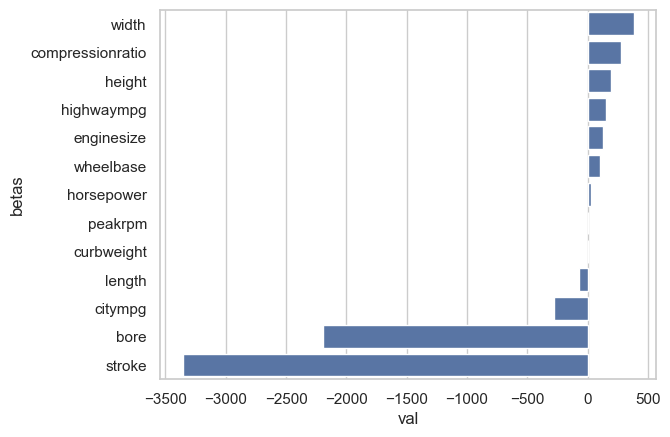

In [420]:
sns.barplot(
    y="betas", x="val", data=df_Betas_with_SE.sort_values("val", ascending=False)
)
plt.show()

**Notes**

The beta coefficients for half of the predictor variables are negative. In other words, a one-unit increase in these variables is likely to lead to a decrease in the value of the response variable, but the magnitude of that decrease is not specified here.

#### Trial-1 Residual Plot

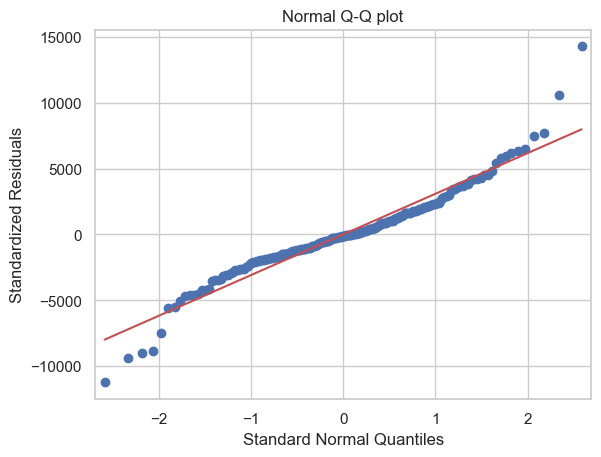

In [421]:
custom_ols_qqplot(_MODEL_FIT.resid)

**Comment**: The Q-Q plot indicates that the residuals are approximately normally distributed.

#### Trial-1 Fitted Vs Residual Plot.

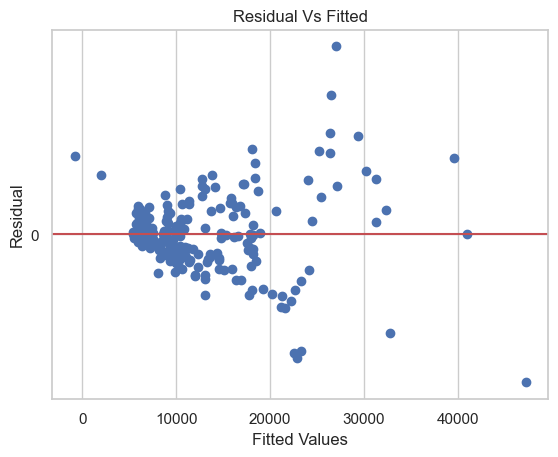

In [422]:
custom_ols_res_vs_fitted(_MODEL_FIT.fittedvalues, _MODEL_FIT.resid)

**Comment**: The fitted vs. residual plot suggests that there is no random scatter of residuals, and there are some clusters

#### Trial-1 VIF Factor

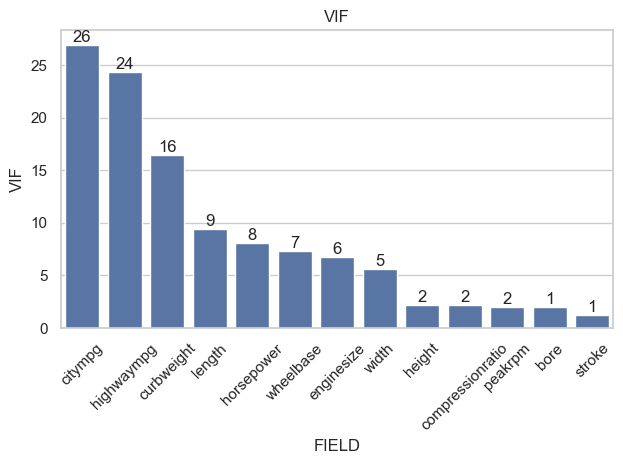

In [423]:
custom_VIF(_model_spec)

**Comment**: 

1. VIF value for the below predictors are high and This suggests that these variables may have multicollinearity with other independent variables in the model.
   
   - citympg
   - hihwaympg
   - curbweight
   - length
   - horsepower
   - wheelbase

2. The below predictors which have VIF less than or equal to 5 are considered to be the better predictors in regression modeling.

   - stroke
   - bore
   - peakrpm
   - compressionratio
   - height
   - width
   - enginesize

#### Best Predictor Variable selection.

In [424]:
los_sel_X = [
    "stroke",
    "bore",
    "peakrpm",
    "compressionratio",
    "height",
    "width",
    "enginesize",
]

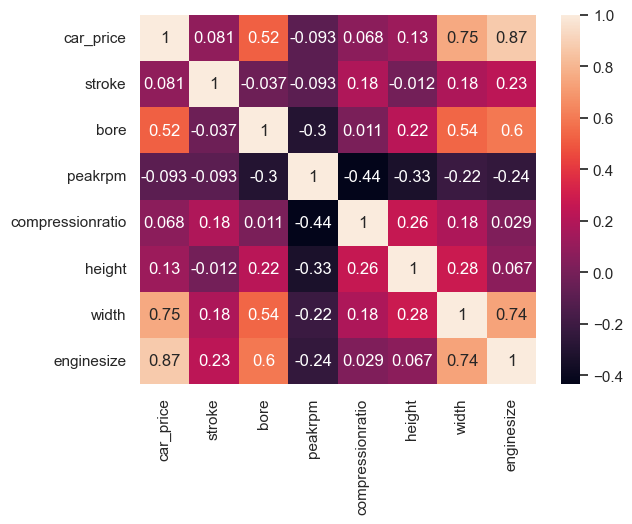

In [443]:
sns.heatmap(df_cars_v1[[ "car_price",
    "stroke",
    "bore",
    "peakrpm",
    "compressionratio",
    "height",
    "width",
    "enginesize"]].corr(),annot=True)
plt.show()

In [425]:
_model_spec_2 = custom_statsmodel_OLS(
    df_cars_v1,
    "car_price",
    "stroke",
    "bore",
    "peakrpm",
    "compressionratio",
    "height",
    "width",
    "enginesize",
)

**Notes**

I have considered these predictors for modeling further to predict the car price and in the next step I will again fit a model with these 7 variables on the outcome variable i.e car price.

   - stroke
   - bore
   - peakrpm
   - compressionratio
   - height
   - width
   - enginesize

#### Trial-2 Model Fitting.

In [426]:
_MODEL_FIT_2 = _model_spec_2.fit()

In [427]:
print(f'Trial-2#The Regression Table:##\n{_MODEL_FIT_2.summary2()}')

Trial-2#The Regression Table:##
                       Results: Ordinary least squares
Model:                   OLS                 Adj. R-squared:        0.828     
Dependent Variable:      car_price           AIC:                   3910.3622 
Date:                    2024-04-12 21:13    BIC:                   3936.9463 
No. Observations:        205                 Log-Likelihood:        -1947.2   
Df Model:                7                   F-statistic:           141.4     
Df Residuals:            197                 Prob (F-statistic):    2.90e-73  
R-squared:               0.834               Scale:                 1.0841e+07
------------------------------------------------------------------------------
                    Coef.     Std.Err.     t    P>|t|     [0.025      0.975]  
------------------------------------------------------------------------------
const            -69002.1067 11171.8990 -6.1764 0.0000 -91033.9744 -46970.2390
stroke            -3610.8033   764.5756 -4.7

**Regression Equation**

$\hat{carprice} = {-69002.1067} +{-3610.80}*\hat{stroke}+{-1265.9900}*\hat{bore}+{3.0327}*\hat{peakrpm}+{199.4428}*\hat{compressionratio}+{177.1516}*\hat{height}+{778.1796}*\hat{width}+{155.9542}*\hat{enginesize}+e$

**Inferences**

1. The fitted model has producted: R-SQuared IS (0.83) adn R-Squared(Adj) is 0.82, here the proportion of variation in Y explained by all the continous predictors is aproximately same as the first fitted model.

2. There are very few variables are not statistically significant. and we will look at the other regression diagnostics.

3. The Most of the betas have got the positive magnitudes unlike the earlier fitted model.

#### Trial-2 Residual Plot

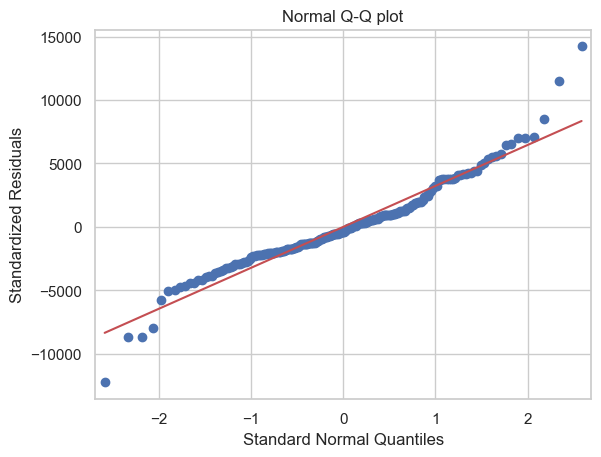

In [428]:
custom_ols_qqplot(_MODEL_FIT_2.resid)

**Comment**: The Q-Q plot indicates that the residuals are approximately normally distributed.

#### Trial-2 Fitted Vs Residual Plot

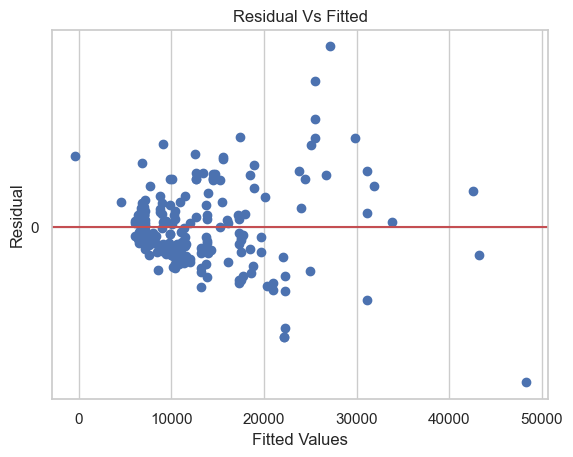

In [429]:
custom_ols_res_vs_fitted(_MODEL_FIT_2.fittedvalues, _MODEL_FIT_2.resid)

**Comment**: The fitted vs. residual plot suggests a random scatter of residuals, with no apparent trends. ofcourse there is a small cluster of points

#### Trial-2 VIF Factor

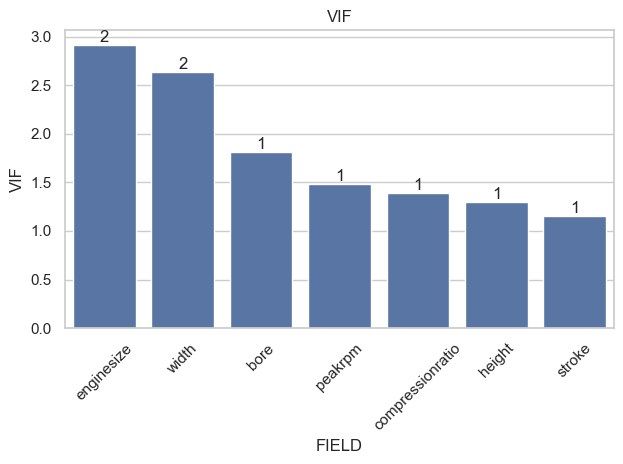

In [430]:
custom_VIF(_model_spec_2)

**Comment**:

1. VIF's are Good for all the 7 predictors and the model can be used to predict the car prict with these predictors


In [431]:
DF_ = pd.concat([df_cars_pd["make"], df_cars_v1], axis=1)

In [432]:
DF_7 = DF_[
    DF_["make"].isin(
        ["toyota", "nissan", "mazda", "mitsubishi", "honda", "subaru", "volkswagen"]
    )
]

#### Model Predictions:

In [433]:
DF_7_summary = DF_7.describe().reset_index()

In [434]:
DF_TO_PREDICT = DF_7_summary.loc[:, los_sel_X]

In [435]:
_df = pd.DataFrame(DF_TO_PREDICT.iloc[1]).T

In [436]:
_df.head()

,stroke,bore,peakrpm,compressionratio,height,width,enginesize
1,3.254017,3.249658,5111.111111,10.080342,53.417949,65.14188,113.299145


**Note:**

1. For these car makes "toyota", "nissan", "mazda", "mitsubishi", "honda", "subaru", "volkswagen" the mean values of each best predictor is caluclated and given them to regression model to predict the car price as below.

In [437]:
custom_model_preds(_MODEL_FIT_2, _df.reset_index())

,predicted_y
0,10469.921082


**Note:**

1. Predicted car price would be 10469 for the given mean values of each predictor variable.